In [92]:
import numpy as np
import matplotlib.pyplot as plt

from tensorflow import keras
from tensorflow.keras import layers, regularizers
from keras.layers import *

import tensorflow as tf

from keras import backend as K

# Auxilary

# Model

## Building block

### Resnet

In [93]:
def resnet_unit(feat_dim, kernel_size, x_in):
    # conv = Conv2D(feats, kernel, padding="same")
    res = keras.Sequential([
        Conv2D(feat_dim,
               kernel_size, padding="same",
               kernel_initializer='he_uniform',
               bias_initializer='he_uniform'),
        ReLU(),
        Conv2D(feat_dim,
               kernel_size,
               padding="same",
               kernel_initializer='he_uniform',
            bias_initializer='he_uniform')
    ])
    return ReLU()(x_in + res(x_in))

def resnet_block(x_in, feat_dim, kernel_size, reps, pooling = True):
    # Stage 2
    conv1 = Conv2D(feat_dim,
                   kernel_size,
                   padding="same",
                   kernel_initializer='he_uniform',
                   bias_initializer='he_uniform')(x_in)
    relu1 = ReLU()(conv1)
    conv2 = Conv2D(feat_dim,
                   kernel_size,
                   padding="same",
                   kernel_initializer='he_uniform',
                   bias_initializer='he_uniform')(relu1)
    x = ReLU()(conv2)
    for _ in range(reps):
        x = resnet_unit(feat_dim,kernel_size,x)
    if pooling == True:
        x = MaxPooling2D(2,2)(x)
        return x
    else:
        return x

### Convolution block

In [94]:
def conv_unit(feat_dim, kernel_size, x):
    x = Conv2D(feat_dim, 
               kernel_size, 
               activation = LeakyReLU(0.2), 
               padding="same", 
               kernel_initializer='he_uniform', 
               bias_initializer='he_uniform')(x)
    x = Conv2D(feat_dim,
               1,
               activation = LeakyReLU(0.2),
               padding="same",
               kernel_initializer='he_uniform',
               bias_initializer='he_uniform')(x)
    return x

def conv_block_down(x, feat_dim, reps, kernel_size, mode = 'normal'):
    if mode == 'down':
        x = MaxPooling2D(2,2)(x)
    for _ in range(reps):
        x = conv_unit(feat_dim, 
                      kernel_size,
                      x)

    return x

def conv_block_up_w_concat(x, x1, feat_dim, reps, kernel_size, mode = 'normal'):
    if mode == 'up':
        x = UpSampling2D((2,2))(x)
    
    x = Concatenate()([x,x1])
    for _ in range(reps):
        x = conv_unit(feat_dim,
                      kernel_size,
                      x)
    return x

def conv_block_up_wo_concat(x, feat_dim, reps, kernel_size, mode = 'normal'):
    if mode == 'up':
        x = UpSampling2D((2,2))(x)
    for _ in range(reps):
        x = conv_unit(feat_dim,
                      kernel_size,
                      x)
    return x

### SPADE

In [95]:
class SPADE(layers.Layer):
    def __init__(self, filters, epsilon=1e-5, **kwargs):
        super().__init__(**kwargs)
        self.epsilon = epsilon
        self.conv = layers.Conv2D(filters, 3, padding="same", activation="relu",kernel_initializer='he_uniform',
               bias_initializer='he_uniform')
        self.conv_gamma = layers.Conv2D(filters, 3, padding="same",kernel_initializer='he_uniform',
               bias_initializer='he_uniform')
        self.conv_beta = layers.Conv2D(filters, 3, padding="same",kernel_initializer='he_uniform',
               bias_initializer='he_uniform')

    def build(self, input_shape):
        self.resize_shape = input_shape[1:3]
        # print(self.resize_shape)

    def call(self, input_tensor, raw_mask):
        mask = tf.image.resize(raw_mask, self.resize_shape, method="nearest")
        x = self.conv(mask)    

        gamma = self.conv_gamma(x)
        beta = self.conv_beta(x)
        mean, var = tf.nn.moments(input_tensor, axes=(0, 1, 2), keepdims=True)
        std = tf.sqrt(var + self.epsilon)

        normalized = (input_tensor - mean) / std
        output = gamma * normalized + beta

        return output

def spade_generator_unit(x, mask, feats_in, kernel, upsampling = True):
    x = GaussianNoise(0.05)(x)
    # SPADE & conv
    spade1 = SPADE(feats_in)(x, mask)
    output = Conv2D(feats_in,kernel, padding='same', activation= LeakyReLU(0.2),kernel_initializer='he_uniform',
               bias_initializer='he_uniform')(spade1)
    if upsampling == True:
        output = UpSampling2D(size = (2,2))(output)
        return output
    else:
        return output

### Adaptive Instance Normalization

In [96]:
class AdaIN(layers.Layer):
    def __init__(self, filters, epsilon=1e-5, **kwargs):
        super().__init__(**kwargs)
        self.epsilon = epsilon
        self.dense = layers.Dense(filters,
                                  activation = 'relu',
                                  kernel_initializer='he_uniform',
                                  bias_initializer='he_uniform')
        self.dense_gamma = layers.Dense(filters,
                                        kernel_initializer='he_uniform',
                                        bias_initializer='he_uniform')
        self.dense_beta = layers.Dense(filters,
                                       kernel_initializer='he_uniform',
                                       bias_initializer='he_uniform')

    def call(self, input_tensor, style_vector):
        x = self.dense(style_vector)
        gamma = self.dense_gamma(x)
        beta = self.dense_beta(x)
        #Normalize x[0]
        mean, var = tf.nn.moments(input_tensor, axes=(0, 1, 2), keepdims=True)
        std = tf.sqrt(var + self.epsilon)
        normalized = (input_tensor - mean) / std
        y = (x[0] - mean) / std

        #Reshape gamma and beta
        pool_shape = [-1, 1, 1, y.shape[-1]]
        gamma = tf.reshape(gamma, pool_shape) + 1.0
        beta = tf.reshape(beta, pool_shape)

        return gamma * normalized + beta

### Feature extraction CNN

In [97]:
def feature_extraction_unet(n_out_features = 128, n_base_features = 64, n_channel = 5):
    inputs = keras.Input(shape = (256,512,n_channel))

    conv1 = conv_block_down(inputs,
                            feat_dim = n_base_features,
                            reps = 1,
                            kernel_size = 3)
    conv2 = conv_block_down(conv1,
                            feat_dim = n_base_features*2,
                            reps = 1,
                            kernel_size = 3,
                            mode = 'down')
    conv3 = conv_block_down(conv2,
                            feat_dim = n_base_features*4,
                            reps = 1,
                            kernel_size = 3,
                            mode = 'down')
    conv4 = conv_block_down(conv3,
                            feat_dim = n_base_features*8,
                            reps = 1,
                            kernel_size = 3,
                            mode = 'down')
    conv5 = conv_block_down(conv4,
                            feat_dim = n_base_features*16,
                            reps = 1,
                            kernel_size = 3,
                            mode = 'down')
    conv6 = conv_block_up_wo_concat(conv5,
                                    feat_dim = n_base_features*8,
                                    reps = 1,
                                    kernel_size = 3,
                                    mode = 'up')
    
    conv7 = conv_block_up_w_concat(conv6, conv3,
                                    feat_dim = n_base_features*4,
                                    reps = 1,
                                    kernel_size = 3,
                                    mode = 'up')
    
    conv8 = conv_block_up_wo_concat(conv7,
                                    feat_dim = n_base_features*2,
                                    reps = 1,
                                    kernel_size = 3,
                                    mode = 'up')
    
    conv9 = conv_block_up_w_concat(conv8, conv1,
                                    feat_dim = n_out_features,
                                    reps = 1,
                                    kernel_size = 3,
                                    mode = 'up')

    feature_out = conv_block_up_wo_concat(conv9,
                                    feat_dim = n_out_features,
                                    reps = 1,
                                    kernel_size = 1,
                                    mode = 'normal')
    unet = keras.Model(inputs, feature_out)
    return unet

### Mapping and reconstruction CNN

In [98]:
def mapping_and_recon_cnn(n_base_features = 64, input_shape = (256,512,128), n_mask_channel = 1, output_channel = 1 ):
    inputs = keras.Input(shape = input_shape)
    inputs_2 = keras.Input(shape = (256,512,n_mask_channel))
    spade1 = spade_generator_unit(inputs,
                                  inputs_2,
                                  128,
                                  1,
                                  upsampling = False)
    conv1 = resnet_block(spade1,
                         feat_dim = n_base_features,
                         kernel_size = 1,
                         reps = 2,
                         pooling = False)
    spade2 = spade_generator_unit(conv1,
                                  inputs_2,
                                  n_base_features,
                                  1,
                                  upsampling = False)
    conv2 = resnet_block(spade2,
                         feat_dim = n_base_features*2,
                         kernel_size = 1,
                         reps = 2,
                         pooling = False)
    
    spade3 = spade_generator_unit(conv2,
                                  inputs_2,
                                  n_base_features*2,
                                  1,
                                  upsampling = False)
    conv3 = resnet_block(spade3,
                         feat_dim = n_base_features*4,
                         kernel_size = 1,
                         reps = 2,
                         pooling = False)
    conv_out = Conv2D(output_channel,1,padding='same')(conv3)
    mapping_resnet = keras.Model([inputs,inputs_2], conv_out)
    return mapping_resnet
# mapping_and_recon_cnn().summary()
# PARCv2

### Advection layer

In [99]:
class Advection(layers.Layer):
    def __init__(self, **kwargs):
        super().__init__(**kwargs)

    def call(self, state_variable, velocity_field):
        dy, dx = tf.image.image_gradients(state_variable)
        spatial_deriv = tf.concat([dy,dx],axis = -1)
        advect = tf.reduce_sum(tf.multiply(spatial_deriv,velocity_field),axis = -1, keepdims=True)
        return advect


### Differentiator CNN

In [100]:
def differentiator(n_state_var = 3):
    feature_extraction = feature_extraction_unet(n_channel=n_state_var+2)
        # Mapping and recon CNN
    mapping_and_recon = []
    advection = []
    for _ in range(n_state_var):
        mapping_and_recon.append(mapping_and_recon_cnn())
        advection.append(Advection())

    velocity_mapping_and_recon = mapping_and_recon_cnn(n_mask_channel = n_state_var, output_channel=2)
    
    init_state_var = keras.layers.Input(shape = (256,512,n_state_var))
    velocity_field = keras.layers.Input(shape = (256,512,2))

    concat1 = keras.layers.concatenate([init_state_var,velocity_field],axis = -1)
    dynamic_feature = feature_extraction(concat1)
    advec = []
    state_var_dot = []
    
    for i in range(n_state_var): 
        advec.append(advection[i](init_state_var[:,:,:,i:i+1],velocity_field))
        state_var_dot.append(mapping_and_recon[i]([dynamic_feature,advec[i]]))

    advec_concat = keras.layers.concatenate(advec,axis = -1)
    state_var_dot_concat = keras.layers.concatenate(state_var_dot,axis = -1)
    
    velocity_dot = velocity_mapping_and_recon([dynamic_feature,advec_concat])
    differentiator = keras.Model([init_state_var, velocity_field], [state_var_dot_concat, velocity_dot])
    return differentiator
    
differentiator(n_state_var=3).summary()

Model: "model_5"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_10 (InputLayer)          [(None, 256, 512, 3  0           []                               
                                )]                                                                
                                                                                                  
 input_11 (InputLayer)          [(None, 256, 512, 2  0           []                               
                                )]                                                                
                                                                                                  
 concatenate_2 (Concatenate)    (None, 256, 512, 5)  0           ['input_10[0][0]',               
                                                                  'input_11[0][0]']         

### Integration CNN

In [101]:
def integrator_cnn(n_base_features = 128, n_output = 1):
    inputs = keras.Input(shape = (256,512,n_output))
    conv1 = resnet_block(inputs,
                         feat_dim = n_base_features,
                         kernel_size = 1,
                         reps = 2,
                         pooling = False)
    conv2 = resnet_block(conv1,
                         feat_dim = n_base_features*2,
                         kernel_size = 1,
                         reps = 2,
                         pooling = False)
    conv3 = resnet_block(conv2,
                         feat_dim = n_base_features*4,
                         kernel_size = 1,
                         reps = 2,
                         pooling = False)
    conv_out = Conv2D(n_output,1,padding='same')(conv3)
    integrator_resnet = keras.Model(inputs, conv_out)
    return integrator_resnet
# integrator_cnn().summary()

In [102]:
def integrator(n_state_var = 3):
    state_integrators = []
    for _ in range(n_state_var):
        state_integrators.append(integrator_cnn())

    velocity_integrator = integrator_cnn(n_output=2)

    state_var_dot = keras.layers.Input(shape = (256,512,n_state_var))
    velocity_dot = keras.layers.Input(shape = (256,512,2))

    state_var_next = []
        
    for i in range(n_state_var): 
        state_var_next.append(state_integrators[i](state_var_dot[:,:,:,i:i+1]))

    state_var_next = keras.layers.concatenate(state_var_next, axis=-1)
    velocity_next = velocity_integrator(velocity_dot)
    integrator = keras.Model([state_var_dot, velocity_dot], [state_var_next, velocity_next])
    return integrator
integrator(n_state_var = 3).summary()

Model: "model_10"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_16 (InputLayer)          [(None, 256, 512, 3  0           []                               
                                )]                                                                
                                                                                                  
 tf.__operators__.getitem_3 (Sl  (None, 256, 512, 1)  0          ['input_16[0][0]']               
 icingOpLambda)                                                                                   
                                                                                                  
 tf.__operators__.getitem_4 (Sl  (None, 256, 512, 1)  0          ['input_16[0][0]']               
 icingOpLambda)                                                                            

### PARCv2

In [105]:
class PARCv2(keras.Model):
    def __init__(self, n_state_var, n_time_step, **kwargs):
        super(PARCv2, self).__init__(**kwargs)
        self.n_state_var = n_state_var
        self.n_time_step = n_time_step
        self.differentiator = differentiator(n_state_var=self.n_state_var)
        self.integrator = integrator(n_state_var=self.n_state_var)

        self.init_state_var = keras.layers.Input(shape = (256,512,self.n_state_var))
        self.velocity_field = keras.layers.Input(shape = (256,512,2))
        self.out = self.call([self.init_state_var, self.velocity_field])

        super(PARCv2, self).__init__(
            inputs=[self.init_state_var, self.velocity_field], outputs=self.out, **kwargs
        )

        # loss define
        self.differentitator_loss_tracker = keras.metrics.Mean(name="differentiator_loss")
        self.state_var_loss_tracker = keras.metrics.Mean(name="state_var_loss_tracker")
        self.total_loss_tracker = keras.metrics.Mean(name="total_loss")

    def build(self):
        self._is_graph_network = True
        self._init_graph_network(
            inputs=[self.init_state_var, self.velocity_field], outputs=self.out
        )

    @property
    def metrics(self):
        return [
        self.total_loss_tracker,
        self.differentitator_loss_tracker,
        self.state_var_loss_tracker,
        ]

    def call(self, inputs, training = True):
        state_var_init = inputs[0]
        velocity_init = inputs[1]

        state_var_all = []
        velocity_all = []
        state_var_dot_all = []
        velocity_dot_all = []
        state_var_current = state_var_init
        velocity_current = velocity_init
        for _ in range(self.n_time_step):
            state_var_dot, velocity_dot = self.differentiator([state_var_current, velocity_current])
            delta_state_var, delta_velocity = self.integrator([state_var_dot, velocity_dot])  

            state_var_current = keras.layers.add([state_var_current, delta_state_var])
            velocity_current = keras.layers.add([velocity_current, delta_velocity])

            state_var_dot_all.append(state_var_dot)
            velocity_dot_all.append(velocity_dot)
            state_var_all.append(state_var_current)
            velocity_all.append(velocity_current)
        
        state_var_dot_all = keras.layers.concatenate(state_var_dot_all, axis = -1)
        state_var_all = keras.layers.concatenate(state_var_all, axis = -1)
        velocity_dot_all = keras.layers.concatenate(velocity_dot_all, axis = -1)
        velocity_all = keras.layers.concatenate(velocity_all, axis = -1)

        return state_var_all, velocity_all, state_var_dot_all, velocity_dot_all

    def train_step(self, data):
        state_var_init = data[0][0]
        velocity_init = data[0][1]

        state_var_gt = data[1][0]
        velocity_gt = data[1][1]
        state_var_dot_gt = data[1][2]
        velocity_dot_gt = data[1][3]

        state_loss = 0
        differentiator_loss = 0

        with tf.GradientTape() as tape:
            # AE loss
            state_var_current = state_var_init
            velocity_current = velocity_init
            for ts in range(self.n_time_step):
                state_var_dot, velocity_dot = self.differentiator([state_var_current, velocity_current])
                delta_state_var, delta_velocity = self.integrator([state_var_dot, velocity_dot])  

                state_var_current = keras.layers.add([state_var_current, delta_state_var])
                velocity_current = keras.layers.add([velocity_current, delta_velocity])

                state_range = (ts*self.n_state_var, ts*self.n_state_var+self.n_state_var-1)
                vel_range = (ts*2, ts*2+1)
                
                differentiator_loss += tf.keras.losses.MeanSquaredError()(state_var_dot,state_var_dot_gt[:,:,:,state_range[0]:state_range[1]]) + \
                                        tf.keras.losses.MeanSquaredError()(velocity_dot,velocity_dot_gt[:,:,:,vel_range[0]:vel_range[1]])
                state_loss += tf.keras.losses.MeanSquaredError()(state_var_current,state_var_gt[:,:,:,:,state_range[0]:state_range[1]]) + \
                                    tf.keras.losses.MeanSquaredError()(velocity_current,velocity_gt[:,:,:,vel_range[0]:vel_range[1]])

            total_loss =  differentiator_loss + state_loss
        
        self.differentitator_loss_tracker.update_state(differentiator_loss)
        self.state_var_loss_tracker.update_state(state_loss) 
        self.total_loss_tracker.update_state(total_loss) 

        grads = tape.gradient(total_loss, self.trainable_weights)
        self.optimizer.apply_gradients(zip(grads, self.trainable_weights))

        return {
            "total_loss": self.total_loss_tracker.result(),
            "differentiator_loss": self.differentitator_loss_tracker.result(),
            "state_var_loss_tracker": self.state_var_loss_tracker.result(),
        }
parc = PARCv2(n_state_var=3,n_time_step=5)
parc.build()
parc.compile()
parc.summary()

Model: "par_cv2_3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_54 (InputLayer)          [(None, 256, 512, 3  0           []                               
                                )]                                                                
                                                                                                  
 input_55 (InputLayer)          [(None, 256, 512, 2  0           []                               
                                )]                                                                
                                                                                                  
 model_27 (Functional)          [(None, 256, 512, 3  19823173    ['input_54[0][0]',               
                                ),                                'input_55[0][0]',       

# Data pipeline

In [71]:
import os
# Data processing: 
# Step 1: read data
# Step 2: chop data into sequences (1-ts length sq, 2-ts length sq, 3-ts length sq, etc.)

def clipping_raw_data_to_small_sequence(sequence_length = 2, n_state_var = 3):
    state_seq_whole = []
    vel_seq_whole = []
    for i in range (200):
        file_path = 'C:/Users/cdy9xh/Work/01.Research/01.PIML/parc-meta/myenv/data/data_processed/coupled_field_with_vel/void_' + str(i) +'.npy'
        if os.path.exists(file_path):
            raw_data_in = np.load(file_path)
            data_shape = np.shape(raw_data_in)
            pad_val_y = 0
            pad_val_x = 0
            if data_shape[0] < 512:
                pad_val_y = abs(data_shape[0]-512)
            if data_shape[1] < 1024:
                pad_val_x = abs(data_shape[1]-1024)
                # print(pad_val_x)
            npad = ((pad_val_y, 0), (0, pad_val_x), (0, 0))

            raw_data_in = np.pad(raw_data_in, pad_width=npad,mode = 'edge')    
            raw_data_in = np.expand_dims(raw_data_in,axis = 0)
            data_shape = np.shape(raw_data_in)

            # print('Void ', str(i))
            # print(data_shape)

            no_of_ts = np.uint8(data_shape[-1]/(n_state_var+2))
            state_seq_case = []
            vel_seq_case = []
            
            for j in range(no_of_ts-sequence_length):
                state_seq = []
                vel_seq = []

                for k in range(sequence_length):
                    state_clip_range = ((j+k)*(n_state_var+2),(j+k)*(n_state_var+2)+n_state_var)
                    vel_clip_range = ((j+k)*(n_state_var+2)+n_state_var,(j+k)*(n_state_var+2)+n_state_var+2)

                    state_seq.append(raw_data_in[:,:,:,state_clip_range[0]:state_clip_range[1]])
                    vel_seq.append(raw_data_in[:,:,:,vel_clip_range[0]:vel_clip_range[1]])

                state_seq_case.append(np.concatenate(state_seq, axis = -1))
                vel_seq_case.append(np.concatenate(vel_seq,axis = -1))

            state_seq_case = np.concatenate(state_seq_case,axis = 0)
            vel_seq_case = np.concatenate(vel_seq_case,axis = 0)

            # print(state_seq_case.shape)

            state_seq_whole.append(state_seq_case)
            vel_seq_whole.append(vel_seq_case)


    state_seq_whole = np.concatenate(state_seq_whole, axis = 0)
    vel_seq_whole = np.concatenate(vel_seq_whole, axis = 0)
    return state_seq_whole, vel_seq_whole

state_seq_whole, vel_seq_whole = clipping_raw_data_to_small_sequence(sequence_length = 2, n_state_var = 3)
# Normalize data

# Step 4: 

In [72]:
print(state_seq_whole.shape)
print(vel_seq_whole.shape)

(3196, 512, 1024, 6)
(3196, 512, 1024, 4)


In [ ]:
for i in range (3196):
    iter_max = np.amax(state_seq_whole[i,:,:,0::3])    
    # iter_min = np.amin(vel_seq_whole[i,:,:,0::2])    
    # if iter_max_u > max_val_u: max_val_u = iter_max_u
    # if iter_min_u < min_val_u: min_val_u = iter_min_u
    print(iter_max)

    # if iter_max_v > max_val_v: max_val_v = iter_max_v
    # if iter_min_v < min_val_v: min_val_v = iter_min_v

    # if iter_max > max_val: max_val = iter_max

# max_val = -1e12
# min_val = 1e-4
# state_seq_whole_test = np.array(state_seq_whole)
# for i in range (20):
#     iter_max = np.amax(state_seq_whole[i,:,:,1::3])    
#     if iter_max > max_val: max_val = iter_max

# Normalizaion
# state_seq_whole[:,:,:,1::3] = ((state_seq_whole[:,:,:,1::3] - min_val)/(max_val - min_val))*2 - 1

In [ ]:
import os
import numpy as np

def clip_raw_data_to_small_sequence(sequence_length=2, n_state_var=3):
    state_seq_whole = []
    vel_seq_whole = []
    for i in range(200):
        file_path = os.path.join('C:', os.sep, 'Users', 'cdy9xh', 'Work', '01.Research', '01.PIML', 'parc-meta', 'myenv', 'data', 'data_processed', 'coupled_field_with_vel', f'void_{i}.npy')
        if os.path.exists(file_path):
            raw_data = np.load(file_path)
            data_shape = raw_data.shape
            npad = ((0, abs(data_shape[0] - 512)), (0, abs(data_shape[1] - 1024)), (0, 0))

            raw_data = np.pad(raw_data, pad_width=npad, mode='edge')
            raw_data = np.expand_dims(raw_data, axis=0)
            data_shape = raw_data.shape

            num_time_steps = data_shape[-1] // (n_state_var + 2)
            state_seq_case = [np.concatenate([raw_data[:, :, :, (j + k) * (n_state_var + 2):\
                                                    (j + k) * (n_state_var + 2) + n_state_var] \
                                                    for k in range(sequence_length)], axis=-1) \
                                                    for j in range(num_time_steps - sequence_length)]
            vel_seq_case = [np.concatenate([raw_data[:, :, :, (j + k) * (n_state_var + 2) +  n_state_var :\
                                                    (j + k) * (n_state_var + 2) + n_state_var + 2] \
                                                    for k in range(sequence_length)], axis=-1) \
                                                    for j in range(num_time_steps - sequence_length)]

            state_seq_whole.extend(state_seq_case)
            vel_seq_whole.extend(vel_seq_case)

    state_seq_whole = np.concatenate(state_seq_whole, axis=0)
    vel_seq_whole = np.concatenate(vel_seq_whole, axis=0)

    return state_seq_whole, vel_seq_whole

In [86]:
# state_seq_whole[:,:,:,0::3] = ((state_seq_whole[:,:,:,0::3] - 300)/(5000 - 300))*2 - 1
# state_seq_whole[:,:,:,1::3] = ((state_seq_whole[:,:,:,1::3] - 1e-4)/(30e9 - 1e-4))*2 - 1
vel_seq_whole[:,:,:,0::2] = ((vel_seq_whole[:,:,:,0::2] + 2875))/(9275 + 2875)*2 - 1
vel_seq_whole[:,:,:,1::2] = ((vel_seq_whole[:,:,:,1::2] + 6865)/(6650 + 6865))*2 - 1

In [91]:
np.save('state_var_sq_len_1.npy',state_seq_whole)
np.save('vel_sq_len_1.npy',state_seq_whole)

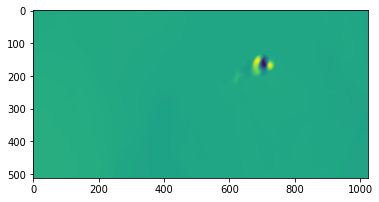

In [90]:
plt.imshow(np.squeeze(vel_seq_whole[100,:,:,1]))#, vmin= -1, vmax = 1)

In [6]:
state_seq_whole[:,:,:,1::3] = (state_seq_whole[:,:,:,1::3] + 1)/2*(50e9 - 1e-4) + 1e-4

In [108]:
import skimage
from skimage.measure import block_reduce

state_seq_whole_train = skimage.measure.block_reduce(np.squeeze(state_seq_whole) , (1,2,2,1),np.max)
vel_seq_whole_train = skimage.measure.block_reduce(np.squeeze(vel_seq_whole) , (1,2,2,1),np.max)


# Training
- The training is based on the idea of stacking delta_t blocks
- PARCv2 will be trained with an incremental for one time step at a time

## Sequence length = 1

In [107]:
# parc = PARCv2(n_state_var = 3, n_time_step = 1)
# parc.build()
# parc.summary()
# parc.compile()
parc.compile(optimizer = tf.keras.optimizers.Adam(lr=0.0001, beta_1 = 0.9, beta_2 = 0.999),metrics=['mse'])
history = parc.fit(x=[state_seq_whole_train[:,:,:,:3],vel_seq_whole_train[:,:,:,:2]], y =[state_seq_whole_train[:,:,:,3:],vel_seq_whole_train[:,:,:,2:]],
                    batch_size=1, epochs = 300)

InternalError: Failed copying input tensor from /job:localhost/replica:0/task:0/device:CPU:0 to /job:localhost/replica:0/task:0/device:GPU:0 in order to run _EagerConst: Dst tensor is not initialized.

## Sequence length = 2

## Sequence length = 3

## Sequence length = 4

## Sequence length = 5

## Sequence length = 6

## Sequence length = 7

## Sequence length = 8

# Validation